In [1]:
# Imports

import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sktime.classification.shapelet_based import MrSEQLClassifier
from sktime.transformations.panel.rocket import MiniRocket
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.transformations.panel.rocket import Rocket

warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", 100)

In [2]:
# Opening up file containing GWAS data and reading in

file = open("Second_GWAS/Second_GWAS_Add.raw", "r")
lines = file.readlines()
len(lines)

110

In [3]:
# Loading GWAS data into DF in the correct format

columns = lines[0].strip("\n").split(" ")
columns = [n.split("_", 1)[0] for n in columns]

df = pd.DataFrame(columns=columns)
data = []

for line in lines[1:]:
    newRow = line.strip("\n").split(" ")
    for position in range(0, len(newRow)):
        if newRow[position] == "0":
            newRow[position] = "2"
        elif newRow[position] == "2":
            newRow[position] = "0"
        
    data.append(newRow)

df = pd.DataFrame(data, columns=columns)

In [4]:
# Checking to see split between cases and controls

df["PHENOTYPE"].value_counts()

1    55
0    54
Name: PHENOTYPE, dtype: int64

In [5]:
# Printing shape of df

df.shape

(109, 41313)

In [6]:
# Printing shape of df

df.columns

Index(['FID', 'IID', 'PAT', 'MAT', 'SEX', 'PHENOTYPE', 'rs7433861',
       'rs1166974', 'rs1166975', 'rs10446372',
       ...
       'rs4030335', 'rs7374010', 'rs9877345', 'rs7373662', 'rs12630742',
       'rs11916265', 'rs7374354', 'rs9325418', 'rs9325420', 'rs10154902'],
      dtype='object', length=41313)

In [7]:
df["PHENOTYPE"] = df["PHENOTYPE"].replace("0","case")
df["PHENOTYPE"] = df["PHENOTYPE"].replace("1","control")

In [8]:
# Dropping columns and seperating phenotype column
phenotype = df.pop("PHENOTYPE")
dfTest = df.drop(columns=["FID","IID","PAT","MAT","SEX"])

In [9]:
# Replacing missing values in df with most common allele for 

imp = SimpleImputer(missing_values="NA", strategy="most_frequent")
idf = pd.DataFrame(imp.fit_transform(dfTest))
idf.columns = dfTest.columns

In [10]:
# Converting columns to be numberical

dfTest = idf.apply(pd.to_numeric)

'case'

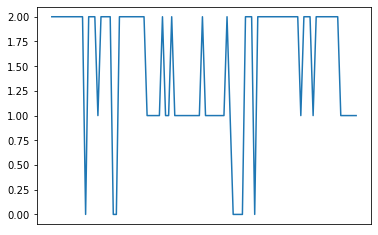

In [11]:
# Visualising first 100 SNPs of first case

dfTranspose = dfTest.T
plt.xticks([])
plt.plot(dfTranspose[0][0:100], color="tab:blue")
phenotype[0]

In [12]:
# Splitting data into training data and testing data

xTrain, xTtest, yTrain, yTest = train_test_split(dfTest, phenotype, train_size=0.7)

In [13]:
# Classifying GWAS data using RandomForest

results = []
for n in range(0,10):
    xTrain, xTtest, yTrain, yTest = train_test_split(dfTest, phenotype, train_size=0.7)
    
    rfc = RandomForestClassifier()
    rfc.fit(xTrain, yTrain)
    
    yPredicted = rfc.predict(xTtest)
    results.append(accuracy_score(yTest, yPredicted))
    
print(f"Average accuracy for RandomForest on entire dataset: {sum(results) / len(results)}")

Average accuracy for RandomForest on entire dataset: 0.5393939393939394


In [14]:
# Converting df to array structure

dfTestSeries = from_2d_array_to_nested(dfTest)

In [17]:
# Classifying GWAS data using MiniRocket

results = []
for n in range(0,10):
    xTrain, xTest, yTrain, yTest = train_test_split(dfTestSeries, phenotype, train_size=0.7)
    minirocket = MiniRocket()
    minirocket.fit(xTrain)
    xTrainTransform = minirocket.transform(xTrain)

    classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
    classifier.fit(xTrainTransform, yTrain)

    xTestTransform = minirocket.transform(xTest)
    yPredict = classifier.predict(xTestTransform)

    results.append(accuracy_score(yTest, yPredict))
    
print(f"Average accuracy for MiniRocket on entire dataset: {sum(results) / len(results)}")

Average accuracy for MiniRocket on entire dataset: 0.47272727272727266


In [18]:
SNPS = ['rs9867035', 'rs7638693', 'rs9837776', 'rs2873392', 'rs6792542',
       'rs1600058', 'rs1580295', 'rs1316579', 'rs834856', 'rs7430111',
       'rs9817983', 'rs2085079', 'rs834858', 'rs834843', 'rs834864',
       'rs9855684', 'rs1598120', 'rs6445172', 'rs9853565', 'rs1097157']

In [19]:
# Classifying GWAS data using RandomForest

results = []
for n in range(0,10):
    xTrain, xTtest, yTrain, yTest = train_test_split(dfTest[SNPS], phenotype, train_size=0.7)
    
    rfc = RandomForestClassifier()
    rfc.fit(xTrain, yTrain)
    
    yPredicted = rfc.predict(xTtest)
    results.append(accuracy_score(yTest, yPredicted))
    
print(f"Average accuracy for RandomForest on selected SNPs: {sum(results) / len(results)}")

Average accuracy for RandomForest on selected SNPs: 0.7969696969696971


In [20]:
dfTestSeries = from_2d_array_to_nested(dfTest[SNPS])

In [21]:
# Classifying GWAS data using MiniRocket

results = []
for n in range(0,10):
    xTrain, xTest, yTrain, yTest = train_test_split(dfTestSeries, phenotype, train_size=0.7)
    minirocket = MiniRocket()
    minirocket.fit(xTrain)
    xTrainTransform = minirocket.transform(xTrain)

    classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
    classifier.fit(xTrainTransform, yTrain)

    xTestTransform = minirocket.transform(xTest)
    yPredict = classifier.predict(xTestTransform)

    results.append(accuracy_score(yTest, yPredict))
    
print(f"Average accuracy for MiniRocket on selected SNPs: {sum(results) / len(results)}")

Average accuracy for MiniRocket on selected SNPs: 0.793939393939394


In [47]:
results = []

for n in range(0,10):
    xTrain, xTest, yTrain, yTest = train_test_split(dfTestSeries, phenotype, train_size=0.7)
    
    ms = MrSEQLClassifier(seql_mode="clf")
    ms.fit(xTrain, yTrain)
    yPredict = ms.predict(xTest)
    results.append(accuracy_score(yTest, yPredict))
    
print(f"Average accuracy for MrSEQL on selected SNP window: {sum(results) / len(results)}")

Average accuracy for MrSEQL on selected SNP window: 0.787878787878788


In [48]:
# Classifying GWAS data using MrSEQL

#ms = MrSEQLClassifier(seql_mode="fs")

#ms.fit(xTrain, yTrain)
#yPredict = ms.predict(xTest)

#print("Accuracy with MrSEQL: %2.3f" % metrics.accuracy_score(yTest, yPredict))
#print(confusion_matrix(yTest, yPredict))
#print(classification_report(yTest, yPredict))

In [23]:
def GenerateWindowsTest(runs, classifierType, windowSize, threshold):

    results = {}
    numberOfWindows = len(dfTest.columns) // windowSize
    
    for k in range(1,runs+1):

        print(f"Run {k}")

        validationScores = []
        testScores = []
        xTrain, xTest, yTrain, yTest = train_test_split(dfTest, phenotype, train_size=0.7)
        xTrainSplit, xValidate, yTrainSplit, yValidate = train_test_split(xTrain, yTrain, train_size=0.7)

        for n in range(0,numberOfWindows):

            if(n%(numberOfWindows//10) == 0 and n != 0):
                print(f"Progress: {round((n/numberOfWindows) * 100)}%")
                
            windowStart = n * windowSize
            windowEnd = windowStart + windowSize
            xTrainWindow = xTrainSplit.iloc[:,windowStart:windowEnd]
            xValidateWindow = xValidate.iloc[:,windowStart:windowEnd]
            
            if classifierType == "MiniRocket":

                xTrainWindowSeries = from_2d_array_to_nested(xTrainWindow)
                xValidateWindowSeries = from_2d_array_to_nested(xValidateWindow)
                minirocket = MiniRocket()
                minirocket.fit(xTrainWindowSeries)
                xTrainTransform = minirocket.transform(xTrainWindowSeries)
                classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
                classifier.fit(xTrainTransform, yTrainSplit)
                xValidateTransform = minirocket.transform(xValidateWindowSeries)
                score = classifier.score(xValidateTransform, yValidate)
            
            elif  classifierType == "MrSEQL":
                
                xTrainWindowSeries = from_2d_array_to_nested(xTrainWindow)
                xValidateWindowSeries = from_2d_array_to_nested(xValidateWindow)
                ms = MrSEQLClassifier(seql_mode="clf")
                ms.fit(xTrainWindowSeries, yTrainSplit)
                yPredict = ms.predict(xValidateWindowSeries)
                score = metrics.accuracy_score(yValidate, yPredict)
            
            elif classifierType == "RandomForest":
                
                rfc = RandomForestClassifier()
                rfc.fit(xTrainWindow, yTrainSplit)
                yPredict = rfc.predict(xValidateWindow)
                score = metrics.accuracy_score(yValidate, yPredict)
            
            validationScores.append(score)

        windowsAboveThreshold = [n for n in range(len(validationScores)) if validationScores[n] > threshold]
        
        print(f"Window positions from validation with accuracy above threshold for run {k}")
        print(windowsAboveThreshold)

        windowsAboveThresholdAfterTest = []

        for n in windowsAboveThreshold:

            windowStart = n * windowSize
            windowEnd = windowStart + windowSize
            xTrainWindow = xTrain.iloc[:,windowStart:windowEnd]
            xTestWindow = xTest.iloc[:,windowStart:windowEnd]
            
            if classifierType == "MiniRocket":
                
                xTrainWindowSeries = from_2d_array_to_nested(xTrainWindow)
                xTestWindowSeries = from_2d_array_to_nested(xTestWindow)
                minirocket = MiniRocket()
                minirocket.fit(xTrainWindowSeries)
                xTrainTransform = minirocket.transform(xTrainWindowSeries)
                classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
                classifier.fit(xTrainTransform, yTrain)
                xTestTransform = minirocket.transform(xTestWindowSeries)
                score = classifier.score(xTestTransform, yTest)
                
            elif  classifierType == "MrSEQL":
                
                xTrainWindowSeries = from_2d_array_to_nested(xTrainWindow)
                xTestWindowSeries = from_2d_array_to_nested(xTestWindow)
                ms = MrSEQLClassifier(seql_mode="clf")
                ms.fit(xTrainWindowSeries, yTrain)
                yPredict = ms.predict(xTestWindowSeries)
                score = metrics.accuracy_score(yTest, yPredict)
            
            elif classifierType == "RandomForest":
                
                rfc = RandomForestClassifier()
                rfc.fit(xTrainWindow, yTrain)
                yPredict = rfc.predict(xTestWindow)
                score = metrics.accuracy_score(yTest, yPredict)
                
            testScores.append(score)

                
        windowsAboveThresholdAfterTest = [windowsAboveThreshold[n] for n in range(len(windowsAboveThreshold)) if testScores[n] > threshold]
        
        print(f"Window positions from validation with accuracy above threshold for run {k}")
        print(windowsAboveThresholdAfterTest)

        for window in windowsAboveThresholdAfterTest:
            if window in results:
                results[window] += 1
            else:
                results[window] = 1
                
    sortedResults = sorted(results.items(), key=lambda x: x[1], reverse=True)
    
    updatedKeyResults = {}
    for key, value in results.items():
        newKeyStart = key*windowSize
        newKeyEnd = newKeyStart + windowSize
        updatedKeyResults[f"{newKeyStart}-{newKeyEnd}"] = value
        
    sortedResults = sorted(updatedKeyResults.items(), key=lambda x: x[1], reverse=True)
    return sortedResults

In [24]:
MiniRocketWindows = GenerateWindowsTest(5, "MiniRocket", 50, 0.6)

Run 1
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 69%
Progress: 79%
Progress: 89%
Progress: 99%
Window positions from validation with accuracy above threshold for run 1
[21, 33, 34, 56, 58, 62, 65, 74, 76, 80, 93, 98, 99, 102, 110, 116, 117, 127, 128, 131, 135, 139, 140, 142, 143, 144, 148, 149, 150, 157, 159, 166, 175, 177, 184, 186, 188, 189, 199, 200, 223, 225, 239, 243, 246, 247, 250, 251, 259, 274, 283, 291, 294, 303, 322, 337, 339, 345, 350, 352, 381, 385, 386, 387, 388, 390, 392, 398, 403, 424, 430, 435, 451, 457, 458, 465, 468, 470, 475, 487, 508, 509, 510, 514, 522, 523, 526, 528, 531, 532, 536, 540, 555, 560, 571, 572, 577, 578, 579, 588, 606, 607, 609, 620, 621, 630, 631, 635, 637, 640, 641, 650, 653, 654, 657, 673, 674, 686, 690, 701, 705, 724, 727, 734, 738, 740, 752, 755, 761, 766, 779, 792, 793, 802, 805, 818, 824]
Window positions from validation with accuracy above threshold for run 1
[33, 34, 116, 127, 128, 144, 157, 1

In [25]:
MrSEQLWindows = GenerateWindowsTest(5, "MrSEQL", 50, 0.6)
RandomForestWindows = GenerateWindowsTest(5, "RandomForest", 50, 0.6)

Run 1
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 69%
Progress: 79%
Progress: 89%
Progress: 99%
Window positions from validation with accuracy above threshold for run 1
[0, 7, 8, 9, 19, 23, 34, 36, 42, 49, 61, 64, 67, 106, 120, 126, 133, 135, 136, 139, 140, 142, 145, 158, 160, 162, 164, 165, 166, 175, 179, 181, 182, 185, 198, 204, 205, 207, 208, 212, 213, 218, 219, 223, 224, 229, 242, 251, 260, 274, 283, 286, 291, 294, 296, 300, 308, 314, 318, 321, 329, 340, 341, 352, 353, 355, 357, 358, 359, 364, 365, 369, 377, 381, 382, 384, 385, 389, 394, 415, 416, 418, 420, 421, 431, 432, 437, 447, 466, 472, 473, 476, 520, 523, 527, 530, 532, 536, 537, 539, 545, 546, 547, 553, 555, 580, 586, 587, 592, 593, 597, 603, 613, 615, 620, 623, 630, 634, 637, 638, 641, 642, 643, 644, 645, 651, 653, 654, 657, 664, 667, 668, 684, 685, 698, 709, 711, 720, 725, 729, 733, 734, 739, 743, 744, 773, 774, 775, 780, 783, 789, 792, 793, 794, 798, 800, 801, 802, 808, 81

Window positions from validation with accuracy above threshold for run 3
[49, 92, 141, 161, 232, 243, 247, 505, 546, 586, 595, 646, 657, 678, 689, 724, 725, 737]
Run 4
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 69%
Progress: 79%
Progress: 89%
Progress: 99%
Window positions from validation with accuracy above threshold for run 4
[10, 15, 25, 34, 50, 56, 57, 60, 61, 63, 77, 84, 105, 112, 114, 119, 122, 127, 142, 153, 164, 165, 166, 168, 177, 178, 184, 187, 189, 191, 193, 196, 203, 204, 205, 208, 224, 226, 235, 243, 245, 256, 264, 265, 272, 285, 287, 290, 291, 293, 300, 314, 319, 322, 323, 324, 328, 330, 333, 334, 341, 344, 346, 352, 357, 361, 365, 367, 373, 374, 394, 405, 417, 420, 428, 430, 447, 448, 454, 460, 462, 470, 473, 477, 485, 490, 491, 492, 496, 497, 499, 505, 510, 511, 514, 516, 521, 527, 530, 552, 560, 563, 569, 571, 572, 574, 592, 596, 600, 603, 607, 608, 609, 611, 616, 625, 628, 629, 632, 633, 634, 641, 642, 643, 645, 651, 

In [55]:
MiniRocketWindows[0:5]

[('1650-1700', 4),
 ('1700-1750', 4),
 ('32050-32100', 4),
 ('6400-6450', 2),
 ('8850-8900', 2)]

In [56]:
MrSEQLWindows[0:5]

[('1700-1750', 3),
 ('39000-39050', 3),
 ('8750-8800', 2),
 ('17900-17950', 2),
 ('32700-32750', 2)]

In [57]:
RandomForestWindows[0:5]

[('21500-21550', 4),
 ('31000-31050', 3),
 ('36650-36700', 3),
 ('1700-1750', 3),
 ('2950-3000', 2)]

In [29]:
dfTest.iloc[:, 1650:1750]

,rs11127780,rs10865598,rs2317203,rs2085079,rs6806513,rs716764,rs716763,rs6785245,rs834854,rs1869517,...,rs9875881,rs17020227,rs1995065,rs6803059,rs13075335,rs6791124,rs9309915,rs9867035,rs2029918,rs9872847
0,0,2,0,2,0,2,0,0,0,1,...,1,2,1,1,2,1,2,1,1,1
1,1,2,0,1,1,2,1,1,1,1,...,1,2,1,1,2,1,2,1,1,1
2,0,2,0,2,0,2,0,0,0,1,...,1,1,2,1,1,1,1,2,1,2
3,1,1,1,1,1,2,1,1,1,1,...,1,1,1,1,1,1,1,2,1,1
4,2,1,1,1,1,2,1,1,1,1,...,2,2,1,2,2,2,2,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,2,1,2,1,2,1,2,2,2,2,...,1,2,1,1,2,1,2,1,1,1
105,1,1,1,1,1,2,1,1,1,1,...,2,2,0,2,2,2,2,2,2,0
106,1,1,1,0,2,2,2,2,2,2,...,1,1,1,1,1,1,1,2,1,1
107,1,1,1,1,1,2,1,1,1,1,...,2,2,0,2,2,2,2,2,2,0


In [43]:
# Classifying GWAS data using RandomForest

results = []
for n in range(0,10):
    xTrain, xTtest, yTrain, yTest = train_test_split(dfTest.iloc[:, 21500:21550], phenotype, train_size=0.7)
    
    rfc = RandomForestClassifier()
    rfc.fit(xTrain, yTrain)
    
    yPredicted = rfc.predict(xTtest)
    results.append(accuracy_score(yTest, yPredicted))
    
print(f"Average accuracy for RandomForest on selected SNP window: {sum(results) / len(results)}")

Average accuracy for RandomForest on selected SNP window: 0.5727272727272729


In [53]:
results = []
for n in range(0,10):
    xTrain, xTest, yTrain, yTest = train_test_split(dfTest.iloc[:, np.r_[1650:1750,32050:32100]], phenotype, train_size=0.7)

    
    xTrain = from_2d_array_to_nested(xTrain)
    xTest = from_2d_array_to_nested(xTest)
    
    minirocket = MiniRocket()
    minirocket.fit(xTrain)
    xTrainTransform = minirocket.transform(xTrain)

    classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
    classifier.fit(xTrainTransform, yTrain)

    xTestTransform = minirocket.transform(xTest)
    yPredict = classifier.predict(xTestTransform)

    results.append(accuracy_score(yTest, yPredict))
    
print(f"Average accuracy for MiniRocket on selected SNP window: {sum(results) / len(results)}")

Average accuracy for MiniRocket on selected SNP window: 0.7363636363636364


In [59]:
results = []

for n in range(0,10):
    xTrain, xTest, yTrain, yTest = train_test_split(dfTest.iloc[:, 1700:1750], phenotype, train_size=0.7)
    
    xTrain = from_2d_array_to_nested(xTrain)
    xTest = from_2d_array_to_nested(xTest)
    
    ms = MrSEQLClassifier(seql_mode="clf")
    ms.fit(xTrain, yTrain)
    yPredict = ms.predict(xTest)
    results.append(accuracy_score(yTest, yPredict))
    
print(f"Average accuracy for MrSEQL on selected SNP window: {sum(results) / len(results)}")

Average accuracy for MrSEQL on selected SNP window: 0.6454545454545456
